In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 导入 alpha_utils 模块中的函数
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))
from alpha_utils import *

sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

### Import & Process data

In [3]:
data = pd.read_pickle('../data/merged_df.pkl')
print(f"# Symbols: {len(data.index.unique('symbol')):,.0f} | # Dates: {len(data.index.unique('Date')):,.0f}")
data.info()

# Symbols: 20 | # Dates: 6,769
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 182763 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          182763 non-null  float64
 1   High          182763 non-null  float64
 2   Low           182763 non-null  float64
 3   Close         182763 non-null  float64
 4   Volume        182763 non-null  float64
 5   id            175994 non-null  object 
 6   symbol_meta   175994 non-null  object 
 7   name          175994 non-null  object 
 8   market_cap    175994 non-null  float64
 9   total_volume  175994 non-null  float64
dtypes: float64(7), object(3)
memory usage: 14.5+ MB


In [4]:
print("Symbols include: ", list(data.index.levels[0]))

Symbols include:  ['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'ICXUSDT', 'IOTAUSDT', 'LINKUSDT', 'LTCUSDT', 'NEOUSDT', 'NULSUSDT', 'ONTUSDT', 'QTUMUSDT', 'TRXUSDT', 'TUSDUSDT', 'USDCUSDT', 'VETUSDT', 'XLMUSDT', 'XRPUSDT']


In [5]:
# remove duplicates
duplicates = data.index.duplicated()
print(data[duplicates].index.unique('symbol'))
data = data[~data.index.duplicated()]
data.info()

Index(['EOSUSDT', 'ETHUSDT', 'USDCUSDT'], dtype='object', name='symbol')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135380 non-null  float64
 1   High          135380 non-null  float64
 2   Low           135380 non-null  float64
 3   Close         135380 non-null  float64
 4   Volume        135380 non-null  float64
 5   id            128611 non-null  object 
 6   symbol_meta   128611 non-null  object 
 7   name          128611 non-null  object 
 8   market_cap    128611 non-null  float64
 9   total_volume  128611 non-null  float64
dtypes: float64(7), object(3)
memory usage: 10.8+ MB


In [6]:
by_symbol = data.groupby(level='symbol')

In [ ]:
# Forward returns
T = [1, 2, 3, 4, 5, 12, 24, 48, 72]
for t in T:
    data[f'ret_{t:02}'] = - by_symbol.Close.pct_change(-t)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135380 non-null  float64
 1   High          135380 non-null  float64
 2   Low           135380 non-null  float64
 3   Close         135380 non-null  float64
 4   Volume        135380 non-null  float64
 5   id            128611 non-null  object 
 6   symbol_meta   128611 non-null  object 
 7   name          128611 non-null  object 
 8   market_cap    128611 non-null  float64
 9   total_volume  128611 non-null  float64
 10  ret_01        135360 non-null  float64
 11  ret_02        135340 non-null  float64
 12  ret_03        135320 non-null  float64
 13  ret_04        135300 non-null  float64
 14  ret_05        135280 non-null  float64
 15  ret_12        135140 no

In [10]:
o = data.Open.unstack('symbol')
h = data.High.unstack('symbol')
l = data.Low.unstack('symbol')
c = data.Close.unstack('symbol')
v = data.Volume.unstack('symbol')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.ret_01.unstack('symbol')

### Alpha 001
```
rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5))
```

Alpha#1 的逻辑是：

- 针对每个股票，选择一个基础指标：当收益为负时用波动性（标准差），否则用收盘价；

- 通过平方操作放大信号差异；

- 在短期内（5个period）找出该信号的峰值出现时间，作为时间特征；

- 最后通过横截面排序标准化信号，得到每个股票该period的因子值。

In [11]:
alpha = 1

In [12]:
def alpha001(c, r):
    """(rank(ts_argmax(power(((returns < 0)
        ? ts_std(returns, 20)
        : close), 2.), 5)) -0.5)"""
    c[r < 0] = ts_std(r, 24)
    return ( rank(ts_argmax(power(c, 2), 12)).mul(-.5) # modified period parameters for hourly data
            .stack().swaplevel() )

In [16]:
ret_col = [c for c in data.columns if 'ret_' in c]
alphas = data[ret_col].copy()

In [ ]:
# %%time
alphas[f'{alpha:03}'] = alpha001(c, r)

CPU times: total: 5.12 s
Wall time: 5.16 s


In [18]:
alphas.dropna(inplace=True)

In [19]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 133263 entries, ('ADAUSDT', Timestamp('2024-07-02 10:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-06 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ret_01  133263 non-null  float64
 1   ret_02  133263 non-null  float64
 2   ret_03  133263 non-null  float64
 3   ret_04  133263 non-null  float64
 4   ret_05  133263 non-null  float64
 5   ret_12  133263 non-null  float64
 6   ret_24  133263 non-null  float64
 7   ret_48  133263 non-null  float64
 8   ret_72  133263 non-null  float64
 9   001     133263 non-null  float64
dtypes: float64(10)
memory usage: 10.9+ MB


#### Distribution visualization

<Axes: xlabel='001', ylabel='Count'>

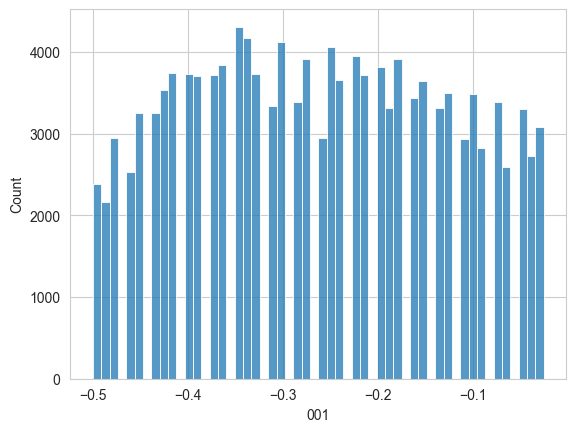

In [20]:
sns.histplot(alphas[f"{alpha:03}"])

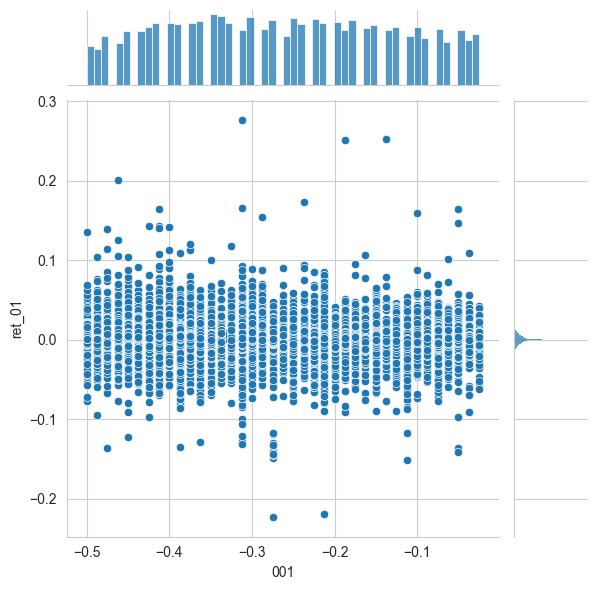

In [22]:
g = sns.jointplot(x=f"{alpha:03}", y='ret_01', data=alphas)

#### Correlation with future return

In [24]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", alphas[f"{alpha:03}"].corr(alphas[c]))

Corr between alpha001 and ret_01 is: -0.05143823951643418
Corr between alpha001 and ret_02 is: -0.035949509850535806
Corr between alpha001 and ret_03 is: -0.028098824411084935
Corr between alpha001 and ret_04 is: -0.024585487674035945
Corr between alpha001 and ret_05 is: -0.022277537893912566
Corr between alpha001 and ret_12 is: -0.02435403778138068
Corr between alpha001 and ret_24 is: -0.017831722482622433
Corr between alpha001 and ret_48 is: -0.015985757442857716
Corr between alpha001 and ret_72 is: -0.012614232782903377


#### Regression

In [25]:
X = sm.add_constant(alphas[f"{alpha:03}"])
model = sm.OLS(alphas['ret_01'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_01   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     353.5
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           9.14e-79
Time:                        11:30:59   Log-Likelihood:             4.2290e+05
No. Observations:              133263   AIC:                        -8.458e+05
Df Residuals:                  133261   BIC:                        -8.458e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011   6.12e-05    -17.692      0.0

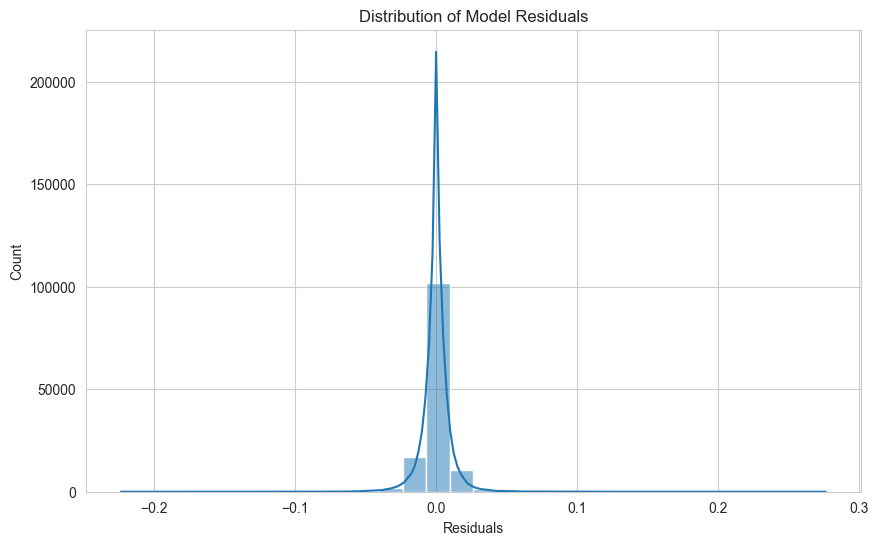

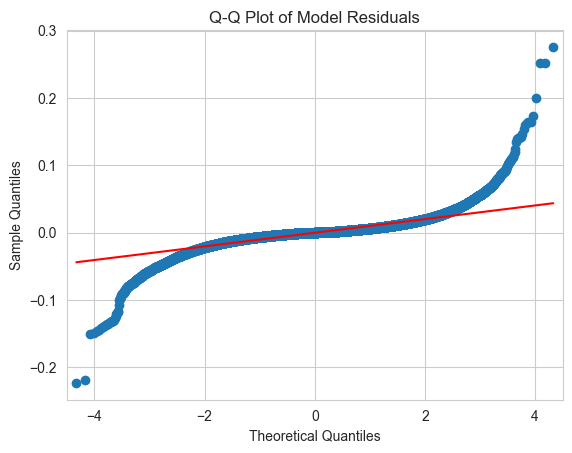

In [26]:
residuals = model.resid

# 1. 绘制直方图和 KDE 曲线
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Model Residuals")
plt.show()

# 2. 绘制 Q-Q 图，检查正态性
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Model Residuals")
plt.show()

### Evaluation for BTC

In [27]:
btc_data = alphas.loc['BTCUSDT'].loc['2025-03-01':'2025-03-31']
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-03-01 00:00:00+00:00 to 2025-03-31 23:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  744 non-null    float64
 1   ret_02  744 non-null    float64
 2   ret_03  744 non-null    float64
 3   ret_04  744 non-null    float64
 4   ret_05  744 non-null    float64
 5   ret_12  744 non-null    float64
 6   ret_24  744 non-null    float64
 7   ret_48  744 non-null    float64
 8   ret_72  744 non-null    float64
 9   001     744 non-null    float64
dtypes: float64(10)
memory usage: 63.9 KB


<Axes: xlabel='001', ylabel='Count'>

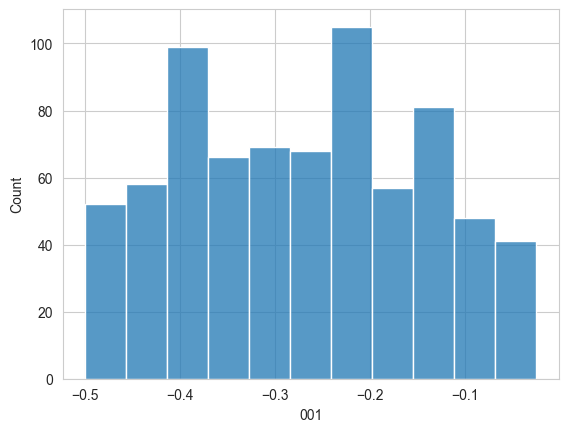

In [28]:
sns.histplot(btc_data[f"{alpha:03}"])

In [29]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", btc_data[f"{alpha:03}"].corr(btc_data[c]))

Corr between alpha001 and ret_01 is: -0.04438815045924839
Corr between alpha001 and ret_02 is: -0.08049874652459921
Corr between alpha001 and ret_03 is: -0.13231374253353356
Corr between alpha001 and ret_04 is: -0.13223294028394444
Corr between alpha001 and ret_05 is: -0.12110752708034982
Corr between alpha001 and ret_12 is: -0.057653900628223675
Corr between alpha001 and ret_24 is: -0.018772693766925374
Corr between alpha001 and ret_48 is: 0.005729474618755355
Corr between alpha001 and ret_72 is: 0.07307106283879719


In [30]:
X = sm.add_constant(btc_data[f"{alpha:03}"])
model = sm.OLS(btc_data['ret_72'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_72   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.983
Date:                Wed, 09 Apr 2025   Prob (F-statistic):             0.0463
Time:                        11:32:07   Log-Likelihood:                 1403.6
No. Observations:                 744   AIC:                            -2803.
Df Residuals:                     742   BIC:                            -2794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.157      0.8

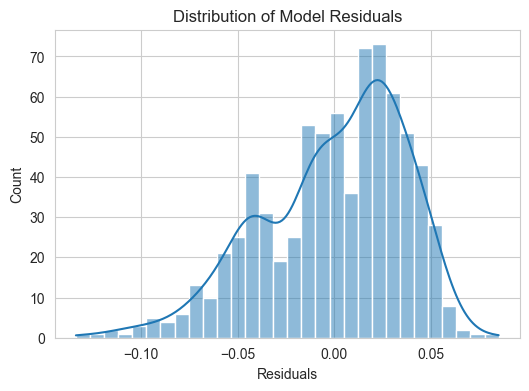

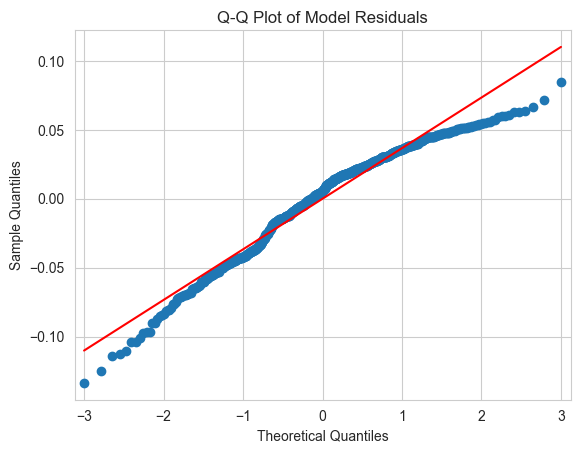

In [31]:
residuals = model.resid

# 1. 绘制直方图和 KDE 曲线
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Model Residuals")
plt.show()

# 2. 绘制 Q-Q 图，检查正态性
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Model Residuals")
plt.show()

### Evaluation for ETH

In [33]:
eth_data = alphas.loc['ETHUSDT'].loc['2025-01-01':'2025-01-31']
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-01-01 00:00:00+00:00 to 2025-01-31 23:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  744 non-null    float64
 1   ret_02  744 non-null    float64
 2   ret_03  744 non-null    float64
 3   ret_04  744 non-null    float64
 4   ret_05  744 non-null    float64
 5   ret_12  744 non-null    float64
 6   ret_24  744 non-null    float64
 7   ret_48  744 non-null    float64
 8   ret_72  744 non-null    float64
 9   001     744 non-null    float64
dtypes: float64(10)
memory usage: 63.9 KB


<Axes: xlabel='001', ylabel='Count'>

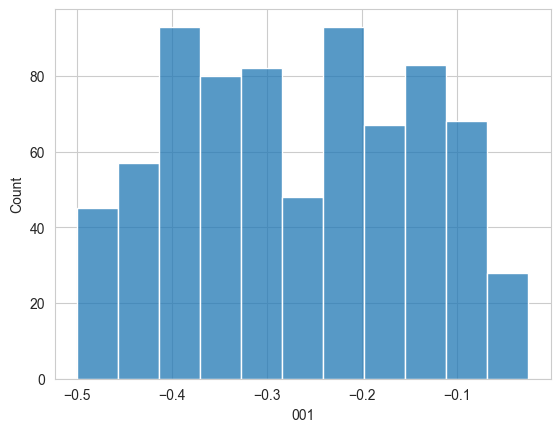

In [34]:
sns.histplot(eth_data[f"{alpha:03}"])

In [35]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", eth_data[f"{alpha:03}"].corr(eth_data[c]))

Corr between alpha001 and ret_01 is: -0.064566941897495
Corr between alpha001 and ret_02 is: -0.07517365304749975
Corr between alpha001 and ret_03 is: -0.0752069081225472
Corr between alpha001 and ret_04 is: -0.057854006713258396
Corr between alpha001 and ret_05 is: -0.04040523143727345
Corr between alpha001 and ret_12 is: -0.05051980762825437
Corr between alpha001 and ret_24 is: -0.05245440793892387
Corr between alpha001 and ret_48 is: -0.01739603579787629
Corr between alpha001 and ret_72 is: -0.02985929773297961


In [36]:
X = sm.add_constant(eth_data[f"{alpha:03}"])
model = sm.OLS(eth_data['ret_02'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_02   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.217
Date:                Wed, 09 Apr 2025   Prob (F-statistic):             0.0404
Time:                        11:32:59   Log-Likelihood:                 2344.2
No. Observations:                 744   AIC:                            -4684.
Df Residuals:                     742   BIC:                            -4675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.953      0.0

### Evaluation for ADA

In [37]:
ada_data = alphas.loc['ADAUSDT'].loc['2025-01-01':'2025-01-31']
ada_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-01-01 00:00:00+00:00 to 2025-01-31 23:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ret_01  744 non-null    float64
 1   ret_02  744 non-null    float64
 2   ret_03  744 non-null    float64
 3   ret_04  744 non-null    float64
 4   ret_05  744 non-null    float64
 5   ret_12  744 non-null    float64
 6   ret_24  744 non-null    float64
 7   ret_48  744 non-null    float64
 8   ret_72  744 non-null    float64
 9   001     744 non-null    float64
dtypes: float64(10)
memory usage: 63.9 KB


<Axes: xlabel='001', ylabel='Count'>

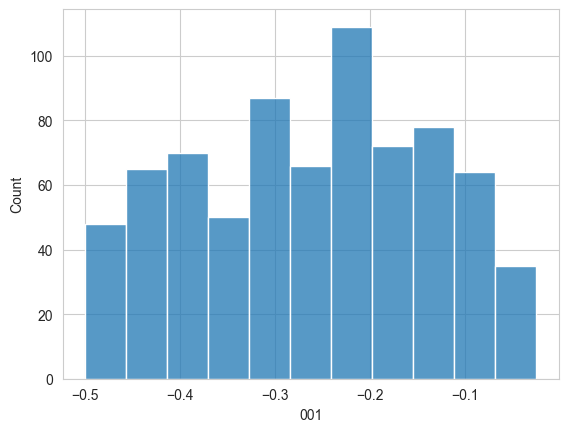

In [38]:
sns.histplot(ada_data[f"{alpha:03}"])

In [39]:
for c in ret_col:
    print(f"Corr between alpha{alpha:03} and {c} is:", ada_data[f"{alpha:03}"].corr(ada_data[c]))

Corr between alpha001 and ret_01 is: -0.1205674288411781
Corr between alpha001 and ret_02 is: -0.08857161003703161
Corr between alpha001 and ret_03 is: -0.038387550102945055
Corr between alpha001 and ret_04 is: 0.0005531809559581611
Corr between alpha001 and ret_05 is: 0.026379483651008673
Corr between alpha001 and ret_12 is: 0.020341197427410432
Corr between alpha001 and ret_24 is: 0.10352439925818138
Corr between alpha001 and ret_48 is: -0.033603122431853275
Corr between alpha001 and ret_72 is: -0.04986104284469829


In [40]:
X = sm.add_constant(ada_data[f"{alpha:03}"])
model = sm.OLS(ada_data['ret_24'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 ret_24   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     8.038
Date:                Wed, 09 Apr 2025   Prob (F-statistic):            0.00470
Time:                        11:33:34   Log-Likelihood:                 1113.9
No. Observations:                 744   AIC:                            -2224.
Df Residuals:                     742   BIC:                            -2215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.005      2.663      0.0